In [145]:
import sklearn
import sklearn.datasets
import torch
import torch.nn as nn
import torch.distributions as dist
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

(3000, 2)


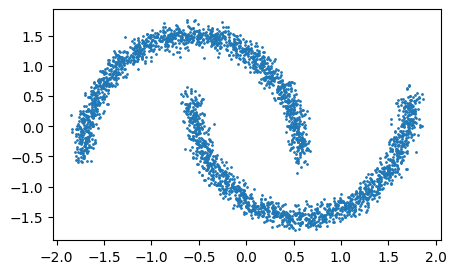

In [146]:
data = sklearn.datasets.make_moons(3000, noise=0.05)[0].astype("float32")
print(data.shape)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
plt.figure(figsize=[5,3])
plt.scatter(x=normalized_data[:,0], y=normalized_data[:,1], s=1)
plt.show()

In [147]:
class Coupling(nn.Module):
    def __init__(self, input_dim, coupling_dim, n_mid=3) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.coupling_dim = coupling_dim
        self.n_mid = n_mid
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        # s : scale
        self.s_layer_in = nn.Linear(self.input_dim, self.coupling_dim)
        self.s_mid_layers = nn.ModuleList(
            [nn.Linear(self.coupling_dim, self.coupling_dim) for _ in range(n_mid)]
        )
        self.s_layer_out = nn.Linear(self.coupling_dim, self.input_dim)

        # t : translation
        self.t_layer_in = nn.Linear(self.input_dim, self.coupling_dim)
        self.t_mid_layers = nn.ModuleList(
            [nn.Linear(self.coupling_dim, self.coupling_dim) for _ in range(n_mid)]
        )
        self.t_layer_out = nn.Linear(self.coupling_dim, self.input_dim)

    def forward(self, input):
        s = self.s_layer_in(input)
        s = self.relu(s)
        for layer in self.s_mid_layers:
            s = layer(s)
            s = self.relu(s)
        s = self.s_layer_out(s)
        s = self.tanh(s)

        t = self.t_layer_in(input)
        t = self.relu(t)
        for layer in self.t_mid_layers:
            t = layer(t)
            t = self.relu(t)
        t = self.t_layer_out(t)

        return s, t

class RealNVP(nn.Module):
    def __init__(self, input_dim, coupling_layers, coupling_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.input_dim = input_dim
        self.coupling_layers = coupling_layers
        self.coupling_dim = coupling_dim

        self.masks = torch.tensor(np.array(
            [[1,0], [0,1]] * (coupling_layers // 2), dtype="float32",
        ))
        self.layers_list = nn.ModuleList(
            Coupling(input_dim, coupling_dim)
            for _ in range(coupling_layers)
        )

    
    def forward(self, x, inverse=True):
        self.masks = self.masks.to(x.device)
        log_det_inv = 0
        direction = 1 # forward mapping (z -> x)
        if inverse: # inverse mapping (x -> z)
            direction = -1
        
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i] # [1,0]-1:d, [0,1]-d+1:n
            reversed_mask = 1 - self.masks[i] 
            s, t = self.layers_list[i](x_masked)
            # 변환이 적용될 부분만 남김
            s = s * reversed_mask
            t = t * reversed_mask 
            gate = (direction - 1) / 2
            x = (
                # 변환되지 않은 부분
                x_masked 
                # 변환할 부분
                + reversed_mask * ( x * torch.exp(direction * s) + direction * t * torch.exp(gate * s))
                # inverse mapping 일때는 direction=-1, x * exp(-s) - t *exp(-s)
                # forward mapping 일때는 direction=1, z * exp(s) + t
             )
            # inverse 일때만 gate = -1
            log_det_inv += gate * torch.sum(s, dim=1)
        return x, log_det_inv
    

In [148]:
def train(model, data, optimizer, total_step, device):
    z_dist = dist.MultivariateNormal(
        loc=torch.zeros(data.shape[1]).to(device), 
        covariance_matrix=torch.eye(data.shape[1]).to(device)
        )
    model.train()
    model = model.to(device)
    loss_history = []
    test_history_z = []
    test_history_sample = []
    
    
    pbar = tqdm(range(total_step))
    for step in pbar:
        optimizer.zero_grad()
        z, log_det_inv = model(data)

        log_likelhood = z_dist.log_prob(z) + log_det_inv
        loss = -torch.mean(log_likelhood)
        loss_history.append(loss.item())
        pbar.set_description(f'step[{step}] - {loss.item():.5f}')
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            # validation
            model.eval()
            z_test = z_dist.sample((data.shape[0],))

            z, _ = model(data)
            g_z_sample, _ = model(z_test, inverse=False)
            test_history_z.append(z.detach().cpu().numpy())
            test_history_sample.append(g_z_sample.detach().cpu().numpy())

    return loss_history, test_history_z, test_history_sample


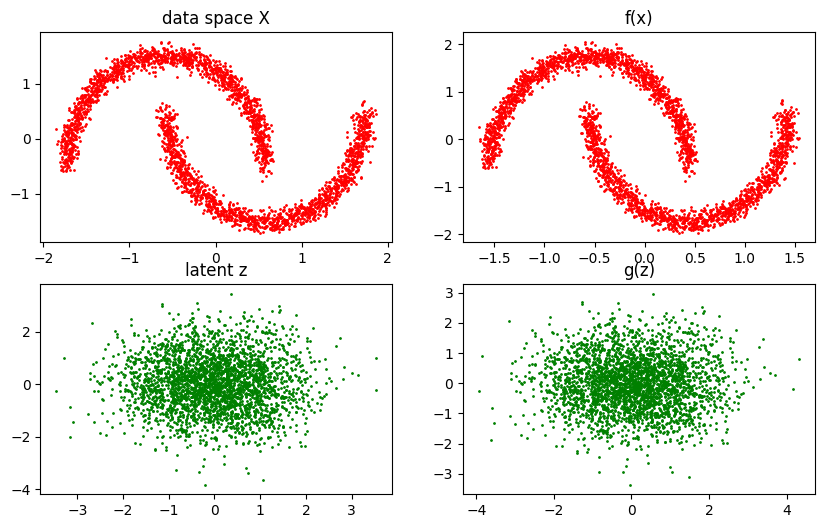

In [149]:
model = RealNVP(
    input_dim=normalized_data.shape[1], 
    coupling_layers=12, 
    coupling_dim=256,
    )

data_tensor = torch.tensor(normalized_data)
z, _ = model(data_tensor, inverse=True) # f(x)
z = z.detach().numpy()
z_dist = dist.MultivariateNormal(
        loc=torch.zeros(data.shape[1]), 
        covariance_matrix=torch.eye(data.shape[1])
    )

z_test = z_dist.sample((data.shape[0],))
g_z_sample, _ = model(z_test, inverse=False)
g_z_sample = g_z_sample.detach().numpy()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
ax[0][0].set(title="data space X")
ax[0][0].scatter(x=normalized_data[:,0], y=[normalized_data[:,1]], s=1, color="r")
ax[0][1].set(title="f(x)")
ax[0][1].scatter(x=z[:,0], y=[z[:,1]], s=1, color="r")
ax[1][0].set(title="latent z")
ax[1][0].scatter(x=z_test[:,0], y=[z_test[:,1]], s=1, color="g")
ax[1][1].set(title="g(z)")
ax[1][1].scatter(x=g_z_sample[:,0], y=[g_z_sample[:,1]], s=1, color="g")


In [150]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data_tensor = data_tensor.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

loss_history, test_history_z, test_history_sample = train(model, data_tensor, optimizer, 500, device)

  0%|          | 0/500 [00:00<?, ?it/s]

step[499] - 1.17805: 100%|██████████| 500/500 [00:10<00:00, 46.64it/s]


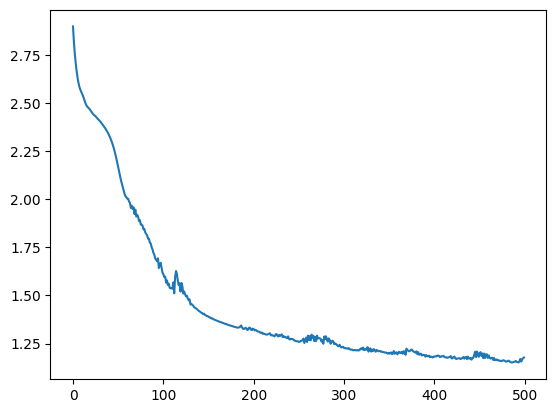

In [151]:
plt.plot(loss_history)
plt.show()

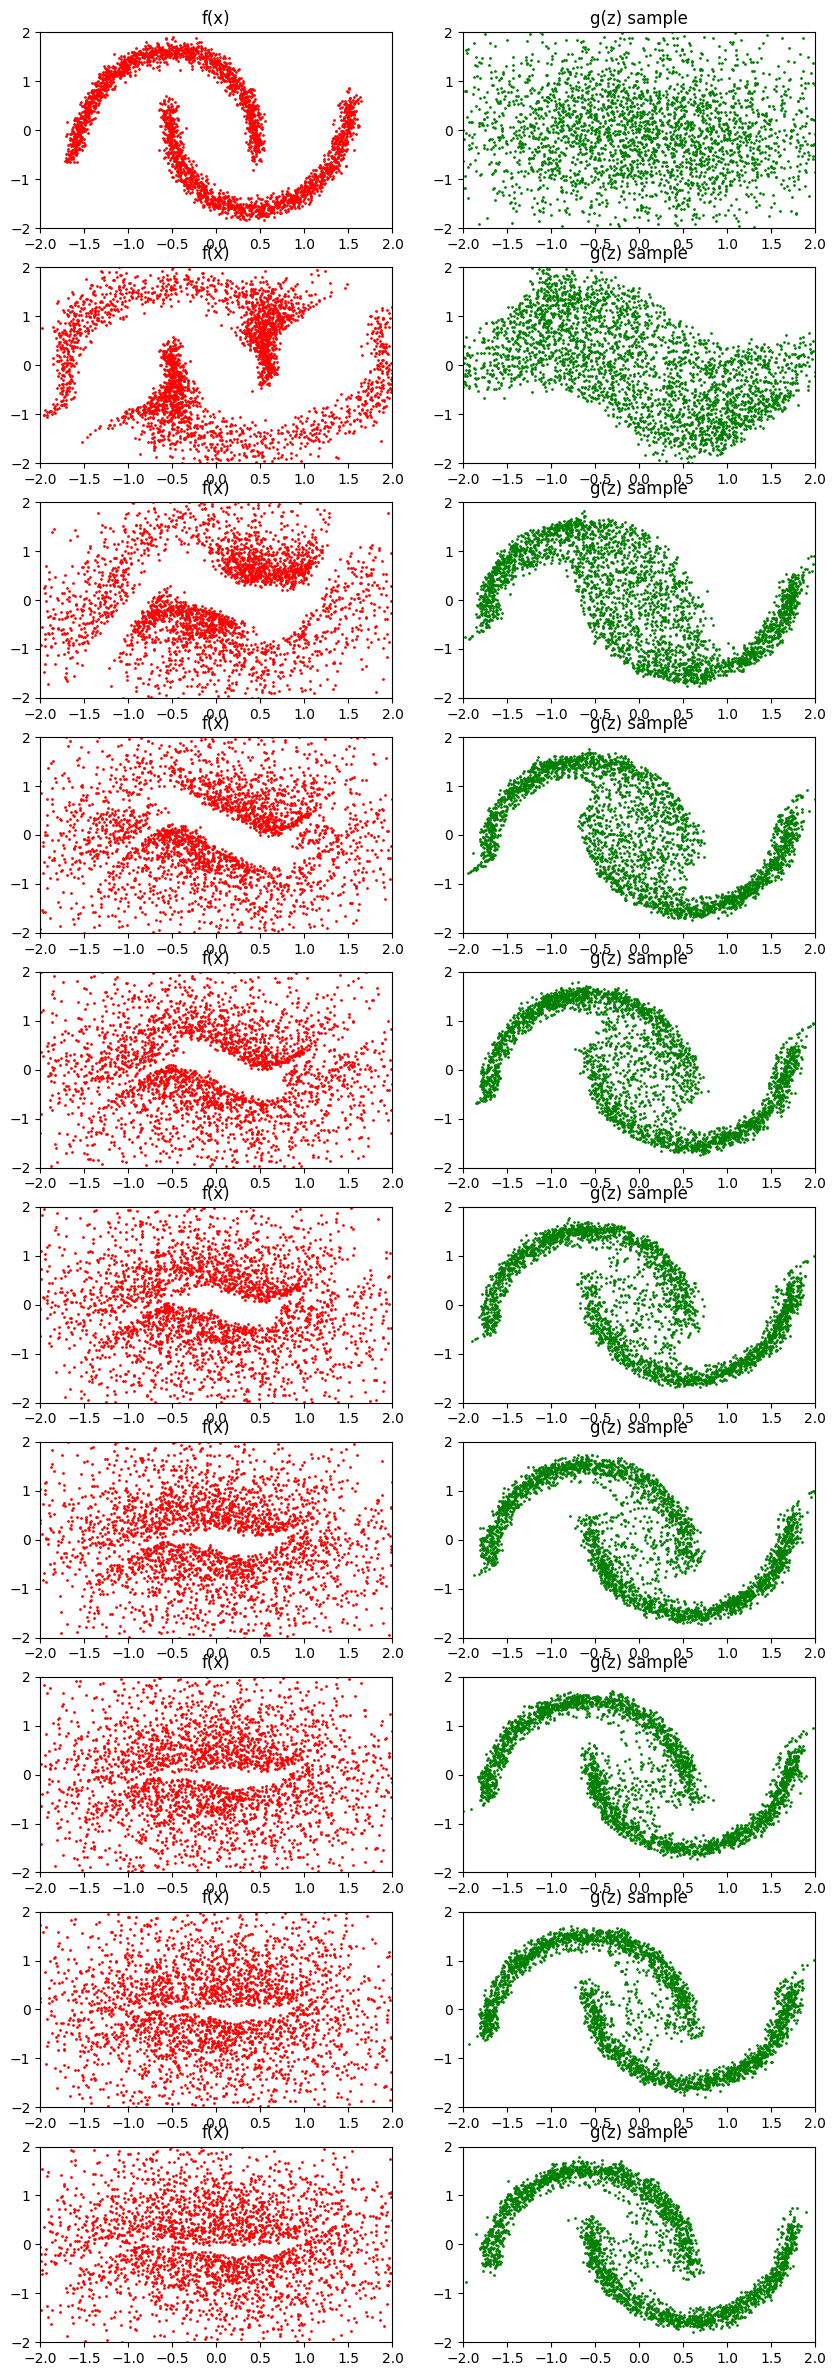

In [152]:
n_row = len(test_history_sample)

fig, ax = plt.subplots(n_row, 2 , figsize = (10, n_row*3))

for i in range(len(test_history_sample)):
    f_x = test_history_z[i]
    g_z_sample = test_history_sample[i]
    
    ax[i, 0].set(title="f(x)")
    ax[i, 0].scatter(x=f_x[:,0], y=f_x[:,1], s=1, color="r")
    ax[i, 0].set_xlim([-2,2])
    ax[i, 0].set_ylim([-2,2])
        
    ax[i, 1].set(title="g(z) sample")
    ax[i, 1].scatter(x=g_z_sample[:,0], y=g_z_sample[:,1], s=1, color="g")
    ax[i, 1].set_xlim([-2,2])
    ax[i, 1].set_ylim([-2,2])


plt.show()
